sources:

https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images?resource=download

https://medium.com/@vineethrajesh2/loading-in-your-own-image-datasets-in-pytorch-9e4064171074

https://www.kaggle.com/code/agnesa/efficientnet-detect-ai-vs-human-generated-images

In [6]:
#assorted
import numpy as np
import os
import psutil
import matplotlib.pyplot as plt
import seaborn as sns #literally only used for the lineplot? surely plt can do that too
from tqdm import tqdm
import random

#torch model
import torch
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Subset
import torch.nn as nn
import torch.nn.functional as F #difference between that and torch.relu or torch.nn.Module.maxpool2d etc?

#metrics
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

#torchcam
from torchcam.methods import SmoothGradCAMpp
from torchcam.utils import overlay_mask
from torchvision.transforms.functional import to_pil_image

In [7]:
#transforms
train_transforms = transforms.Compose([
    transforms.ToTensor(), #can also do some resizing and normalizing
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), #mean and std for normalization
	transforms.RandomHorizontalFlip(), #randomly flip the image horizontally
])

test_transforms = transforms.Compose([
    transforms.ToTensor(), #can also do some resizing and normalizing
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [8]:
#get num_workers, device, batch size
def count_workers() -> int: 
	try:
		vCPUs = os.cpu_count() 
		if vCPUs is None: 
			vCPUs = psutil.cpu_count(logical = False)
		return vCPUs
	except Exception as e:
		return 1
	

workers=count_workers()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 128
epochs = 60
lr=0.001

print(f"cores: {workers}, device: {device}, batch_size: {batch_size}, epochs: {epochs}, learning rate: {lr}")

cores: 16, device: cuda, batch_size: 128, epochs: 60, learning rate: 0.001


In [9]:
#load actual data
train_data = ImageFolder("../data_test/train", transform=train_transforms)
test_data = ImageFolder("../data_test/test", transform=test_transforms)

#dataloaders
train_loader = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True,
    #collate_fn=collate, #collate_fn is used to combine multiple samples into a batch
    num_workers=workers, #number of workers to LOAD data in parallel (not to crunch numbers. for some reason it's different)
    persistent_workers=True,
    pin_memory=True, #pin_memory is used to speed up data transfer to GPU
    pin_memory_device=str(device),
	)
test_loader = DataLoader(
    test_data,
    batch_size=batch_size,
    shuffle=False,
    num_workers=workers,
    persistent_workers=True,
    pin_memory=True,
    pin_memory_device=str(device),
    )

In [10]:
#check how many images in the dataset
print(len(train_data)) #100k
print(len(test_data)) #20k

#check the classes
print(type(train_data)) #torchvision.datasets.folder.ImageFolder
# print(train_data.classes) #0 is fake and 1 is real
# print(test_data.classes)

#check the shape of the images
print(train_data[0][0].shape) #3 channels, 32 x 32 px
print(train_data[0]) #0 or 1, fake or real

100000
20000
<class 'torchvision.datasets.folder.ImageFolder'>
torch.Size([3, 32, 32])
(tensor([[[0.4471, 0.4667, 0.4588,  ..., 0.4863, 0.4157, 0.2118],
         [0.4980, 0.4980, 0.4863,  ..., 0.4039, 0.3176, 0.1804],
         [0.5216, 0.5020, 0.4902,  ..., 0.2824, 0.1961, 0.1569],
         ...,
         [0.1412, 0.1451, 0.1529,  ..., 0.3490, 0.3451, 0.3490],
         [0.1412, 0.1490, 0.1569,  ..., 0.3647, 0.3451, 0.3412],
         [0.1373, 0.1451, 0.1647,  ..., 0.3922, 0.3882, 0.3843]],

        [[0.4392, 0.4588, 0.4588,  ..., 0.4706, 0.4000, 0.1961],
         [0.4902, 0.4902, 0.4863,  ..., 0.3882, 0.3020, 0.1647],
         [0.5137, 0.4941, 0.4902,  ..., 0.2667, 0.1804, 0.1451],
         ...,
         [0.1059, 0.1098, 0.1176,  ..., 0.3216, 0.3176, 0.3216],
         [0.1137, 0.1216, 0.1294,  ..., 0.3294, 0.3176, 0.3137],
         [0.1176, 0.1255, 0.1373,  ..., 0.3569, 0.3569, 0.3529]],

        [[0.4431, 0.4627, 0.4510,  ..., 0.4667, 0.3961, 0.1922],
         [0.4941, 0.4941, 0.4784,  

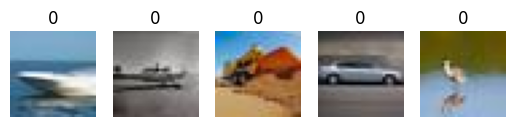

In [11]:
#print n images in train_data starting from starting_index
n_images = 5
starting_index=3908
for i in range(n_images):
	plt.subplot(1, 5, i + 1) #subplot with 1 row and 5 columns
	plt.imshow(train_data[starting_index + i][0].permute(1, 2, 0)) #permute to get channels last
	plt.title(train_data[starting_index + i][1]) #show the label of the image, 0 is the index of the image
	plt.axis('off') #remove axis
plt.show()

In [12]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [13]:
#initialize model
model = CNN()
model

CNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [14]:
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)
criterion = nn.CrossEntropyLoss()

In [ ]:
#training loop
def train_cnn(model: nn.Module, train_loader, test_loader, epochs: int = 1000):
	print(f"Training on {device}")
	# Convert everything to tensors first
	loss_ls = []
	f1_ls = []
	model = model.to(device)

	for epoch in tqdm(range(epochs)):
		model.train()
		for features, target in train_loader:
			features, target = features.to(device), target.to(device)	
			optimizer.zero_grad()
			outputs = model(features)
			loss = criterion(outputs, target)
			loss.backward()
			optimizer.step()

		model.eval()
		#with torch.no_grad():
		total_loss = 0
		combined = []
		for features, target in test_loader:
			features, target = features.to(device), target.to(device)
			output = model(features)
			loss = criterion(output, target)
			total_loss += loss.item()
			label_out = torch.argmax(output, dim=1) #argmax returns the index of the maximum value in the tensor
			combined.append((label_out, target))
			
		f1 = [f1_score(c[0].cpu().numpy(), c[1].cpu().numpy()) for c in combined]
		loss_ls.append(total_loss / len(test_loader))
		f1_ls.append(np.mean(f1))
		print(f"Epoch {epoch + 1} - Loss: {total_loss / len(test_loader)} - F1 Score: {np.mean(f1)}") #is something wrong with my f1 score here? take fake/fake as true positive or real/real as true positive?
	return loss_ls, f1_ls

In [16]:
loss_ls, f1_ls = train_cnn(model, train_loader, test_loader, epochs)

Training on cuda


  2%|▏         | 1/60 [04:53<4:48:11, 293.07s/it]

Epoch 1 - Loss: 0.44062600963434595 - F1 Score: 0.44958286878614606


  3%|▎         | 2/60 [05:14<2:08:45, 133.20s/it]

Epoch 2 - Loss: 0.3507320498395118 - F1 Score: 0.4767975838057549


  5%|▌         | 3/60 [05:26<1:14:13, 78.13s/it] 

Epoch 3 - Loss: 0.31925131266663787 - F1 Score: 0.47737766569703455


  7%|▋         | 4/60 [05:39<48:45, 52.23s/it]  

Epoch 4 - Loss: 0.2735092079943153 - F1 Score: 0.4838338872448528


  8%|▊         | 5/60 [05:52<34:56, 38.12s/it]

Epoch 5 - Loss: 0.2732368259672906 - F1 Score: 0.4571348323818787


 10%|█         | 6/60 [06:05<26:42, 29.67s/it]

Epoch 6 - Loss: 0.24564430165063045 - F1 Score: 0.47103117893670304


 12%|█▏        | 7/60 [06:19<21:43, 24.59s/it]

Epoch 7 - Loss: 0.23784284165520578 - F1 Score: 0.4699517384657296


 13%|█▎        | 8/60 [06:32<17:59, 20.76s/it]

Epoch 8 - Loss: 0.2179706237593274 - F1 Score: 0.4767290698700082


 15%|█▌        | 9/60 [06:45<15:27, 18.18s/it]

Epoch 9 - Loss: 0.23052281796172924 - F1 Score: 0.46634108958053067


 17%|█▋        | 10/60 [06:57<13:38, 16.37s/it]

Epoch 10 - Loss: 0.2122639772144093 - F1 Score: 0.48850287564427963


 18%|█▊        | 11/60 [07:09<12:25, 15.21s/it]

Epoch 11 - Loss: 0.21223598673560057 - F1 Score: 0.48995518023258855


 20%|██        | 12/60 [07:22<11:32, 14.43s/it]

Epoch 12 - Loss: 0.21007100753723437 - F1 Score: 0.4797674810149443


 22%|██▏       | 13/60 [07:35<10:52, 13.87s/it]

Epoch 13 - Loss: 0.19999319813243902 - F1 Score: 0.4762974417238426


 23%|██▎       | 14/60 [07:48<10:24, 13.57s/it]

Epoch 14 - Loss: 0.19188013943327462 - F1 Score: 0.48564562090665336


 25%|██▌       | 15/60 [08:00<09:54, 13.21s/it]

Epoch 15 - Loss: 0.23072084051313674 - F1 Score: 0.4933865533769394


 27%|██▋       | 16/60 [08:13<09:35, 13.08s/it]

Epoch 16 - Loss: 0.20344823133793605 - F1 Score: 0.4779013042331419


 28%|██▊       | 17/60 [08:25<09:11, 12.83s/it]

Epoch 17 - Loss: 0.20717047313880768 - F1 Score: 0.49165144215953677


 30%|███       | 18/60 [08:37<08:51, 12.65s/it]

Epoch 18 - Loss: 0.19643366887311267 - F1 Score: 0.49073943117305563


 32%|███▏      | 19/60 [08:50<08:35, 12.57s/it]

Epoch 19 - Loss: 0.1900648881865155 - F1 Score: 0.47943314958297734


 33%|███▎      | 20/60 [09:02<08:16, 12.40s/it]

Epoch 20 - Loss: 0.17845830530118031 - F1 Score: 0.48240247220614807


 35%|███▌      | 21/60 [09:14<08:06, 12.46s/it]

Epoch 21 - Loss: 0.19365191210512142 - F1 Score: 0.4750712688871432


 37%|███▋      | 22/60 [09:26<07:50, 12.37s/it]

Epoch 22 - Loss: 0.2220617740231145 - F1 Score: 0.49214749047833495


 38%|███▊      | 23/60 [09:39<07:36, 12.34s/it]

Epoch 23 - Loss: 0.19395150405586145 - F1 Score: 0.4766857200930282


c:\Users\yiann\miniconda3\envs\ML\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yiann\miniconda3\envs\ML\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yiann\miniconda3\envs\ML\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yiann\m

Epoch 24 - Loss: 0.35600763322061796 - F1 Score: 0.4213309273553429


 42%|████▏     | 25/60 [10:03<07:11, 12.33s/it]

Epoch 25 - Loss: 0.19062089848860053 - F1 Score: 0.4883567236553294


 43%|████▎     | 26/60 [10:16<07:04, 12.48s/it]

Epoch 26 - Loss: 0.1874287386134172 - F1 Score: 0.4880629285908592


c:\Users\yiann\miniconda3\envs\ML\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 45%|████▌     | 27/60 [10:28<06:48, 12.37s/it]

Epoch 27 - Loss: 0.19929825075587648 - F1 Score: 0.47211303934536797


 47%|████▋     | 28/60 [10:40<06:34, 12.34s/it]

Epoch 28 - Loss: 0.1828668992610494 - F1 Score: 0.4809702648328251


 48%|████▊     | 29/60 [10:54<06:33, 12.71s/it]

Epoch 29 - Loss: 0.1772970795441585 - F1 Score: 0.4781472219822346


c:\Users\yiann\miniconda3\envs\ML\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yiann\miniconda3\envs\ML\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 50%|█████     | 30/60 [11:07<06:26, 12.88s/it]

Epoch 30 - Loss: 0.2224329570723567 - F1 Score: 0.4643071817206275


 52%|█████▏    | 31/60 [11:20<06:11, 12.80s/it]

Epoch 31 - Loss: 0.19223732501268387 - F1 Score: 0.4791986217673231


 53%|█████▎    | 32/60 [11:32<05:52, 12.61s/it]

Epoch 32 - Loss: 0.2005469686096641 - F1 Score: 0.4930193033234854


 55%|█████▌    | 33/60 [11:44<05:38, 12.54s/it]

Epoch 33 - Loss: 0.18649037222668624 - F1 Score: 0.49127042689496186


 57%|█████▋    | 34/60 [11:57<05:22, 12.40s/it]

Epoch 34 - Loss: 0.17736780244833344 - F1 Score: 0.4853170442307043


 58%|█████▊    | 35/60 [12:09<05:08, 12.33s/it]

Epoch 35 - Loss: 0.20050695543266406 - F1 Score: 0.4814833413677344


 60%|██████    | 36/60 [12:21<04:55, 12.32s/it]

Epoch 36 - Loss: 0.1877660094315459 - F1 Score: 0.49309467174940613


 62%|██████▏   | 37/60 [12:33<04:42, 12.27s/it]

Epoch 37 - Loss: 0.17875921814020274 - F1 Score: 0.47680452116015193


 63%|██████▎   | 38/60 [12:45<04:30, 12.29s/it]

Epoch 38 - Loss: 0.17392499787602456 - F1 Score: 0.48634163670810815


 65%|██████▌   | 39/60 [12:58<04:21, 12.45s/it]

Epoch 39 - Loss: 0.18301297112065515 - F1 Score: 0.48593235823504843


c:\Users\yiann\miniconda3\envs\ML\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 67%|██████▋   | 40/60 [13:14<04:26, 13.35s/it]

Epoch 40 - Loss: 0.22479821136517888 - F1 Score: 0.4668898306676746


 68%|██████▊   | 41/60 [13:28<04:19, 13.67s/it]

Epoch 41 - Loss: 0.1980369294619864 - F1 Score: 0.4920739440173706


 70%|███████   | 42/60 [13:41<04:00, 13.39s/it]

Epoch 42 - Loss: 0.19638585149767293 - F1 Score: 0.4920333405312195


 72%|███████▏  | 43/60 [13:53<03:42, 13.11s/it]

Epoch 43 - Loss: 0.26312282278089766 - F1 Score: 0.4925957645631087


 73%|███████▎  | 44/60 [14:05<03:24, 12.80s/it]

Epoch 44 - Loss: 0.19777114869682652 - F1 Score: 0.48799869446301697


 75%|███████▌  | 45/60 [14:18<03:10, 12.70s/it]

Epoch 45 - Loss: 0.2105235490758138 - F1 Score: 0.49476100179246824


 77%|███████▋  | 46/60 [14:30<02:55, 12.51s/it]

Epoch 46 - Loss: 0.19106038218470894 - F1 Score: 0.4816200571711552


 78%|███████▊  | 47/60 [14:42<02:42, 12.48s/it]

Epoch 47 - Loss: 0.18721754977088065 - F1 Score: 0.4905497065034645


 80%|████████  | 48/60 [14:55<02:28, 12.38s/it]

Epoch 48 - Loss: 0.18946458532172403 - F1 Score: 0.48711711775853206


 82%|████████▏ | 49/60 [15:07<02:15, 12.35s/it]

Epoch 49 - Loss: 0.18477412465081852 - F1 Score: 0.4794026142927703


 83%|████████▎ | 50/60 [15:19<02:03, 12.31s/it]

Epoch 50 - Loss: 0.18219386567925192 - F1 Score: 0.48548978019962913


 85%|████████▌ | 51/60 [15:31<01:50, 12.23s/it]

Epoch 51 - Loss: 0.2174955030464253 - F1 Score: 0.4697620243188841


 87%|████████▋ | 52/60 [15:43<01:37, 12.19s/it]

Epoch 52 - Loss: 0.19226903024657516 - F1 Score: 0.47558245701054297


 88%|████████▊ | 53/60 [15:55<01:25, 12.19s/it]

Epoch 53 - Loss: 0.18492532288952238 - F1 Score: 0.483319112702354


 90%|█████████ | 54/60 [16:08<01:13, 12.20s/it]

Epoch 54 - Loss: 0.1781472616182391 - F1 Score: 0.48307019879603075


 92%|█████████▏| 55/60 [16:20<01:01, 12.21s/it]

Epoch 55 - Loss: 0.19121077405229495 - F1 Score: 0.4910483718833166


 93%|█████████▎| 56/60 [16:32<00:48, 12.16s/it]

Epoch 56 - Loss: 0.19755806788137764 - F1 Score: 0.47469526090116837


c:\Users\yiann\miniconda3\envs\ML\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yiann\miniconda3\envs\ML\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yiann\miniconda3\envs\ML\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yiann\m

Epoch 57 - Loss: 0.25521462987277915 - F1 Score: 0.4584548230189305


 97%|█████████▋| 58/60 [16:58<00:25, 12.64s/it]

Epoch 58 - Loss: 0.19440573162049246 - F1 Score: 0.47947716158627574


 98%|█████████▊| 59/60 [17:11<00:12, 12.76s/it]

Epoch 59 - Loss: 0.18335404726350382 - F1 Score: 0.48546514407904673


100%|██████████| 60/60 [17:25<00:00, 17.42s/it]

Epoch 60 - Loss: 0.19374383910066761 - F1 Score: 0.49150271906681825


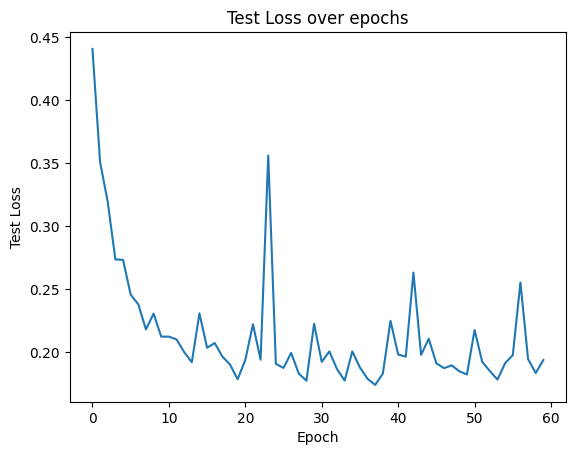

In [17]:
sns.lineplot(loss_ls)
plt.xlabel("Epoch")
plt.ylabel("Test Loss")
plt.title("Test Loss over epochs")
plt.show();

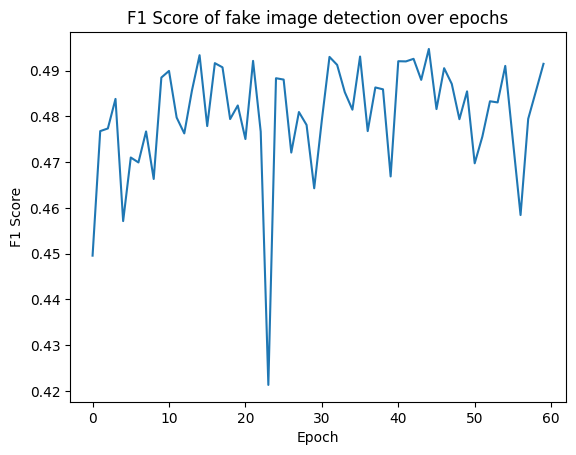

In [18]:
#test accuracy
sns.lineplot(f1_ls)
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.title("F1 Score of fake image detection over epochs")
plt.show();

In [19]:
# #save the model
# torch.save(model.state_dict(), "model.pth")

In [20]:
def display_cam(index, target_layer):
	image_tensor = test_data[index]
	real_class=image_tensor[1]
	image=image_tensor[0].permute(1, 2, 0)
	image_tensor = image_tensor[0].unsqueeze(0)

	#load the model
	model = CNN()
	model.load_state_dict(torch.load("model.pth"))
	#load the model to the same device as before
	model = model.to(device)
	model.eval()

	#get the cam extractor
	cam_extractor = SmoothGradCAMpp(model, target_layer=target_layer)

	#load the model
	model = CNN()
	model.load_state_dict(torch.load("model.pth"))
	#load the model to the same device as before
	model = model.to(device)
	model.eval()

	output = model(image_tensor.to(device))

	with SmoothGradCAMpp(model, target_layer=target_layer) as cam_extractor:
		output = model(image_tensor.to(device)) #move the image tensor to the same device as the model
		activation_map = cam_extractor(output.squeeze(0).argmax().item(), output)


	#print actual vs prediction
	predicted_class = output.argmax(dim=1).item()# # Set your CAM extractor
	print(f"Index: {index}\nActual class: {"Fake (0)" if real_class==0 else "Real (1)"}, Predicted class: {"Fake (0)" if predicted_class==0 else "Real (1)"}")

	#overlay the CAM on the image
	result = overlay_mask(to_pil_image(image_tensor[0]), to_pil_image(activation_map[0].squeeze(0), mode='F'), alpha=0.5)

	#plot
	#print n images in train_data starting from starting_index
	plt.subplot(1, 2, 1) #subplot with 1 row and 5 columns
	plt.title("Original Image")
	plt.imshow(image)
	plt.axis('off')
	plt.subplot(1, 2, 2)
	plt.title("CAM Overlay")
	plt.imshow(result)
	plt.axis('off')


In [69]:
# Get a random image by index, as an image tensor
index=random.randint(10000, 20000) #randomly select an index from the test data
# ls=[400, 422, 437, 461, 464, 541, 542, 543, 550, 555, 569, 580, 597, 616, 646, 667, 714, 723, 758, 770, 790, 792, 799]
#real img pred fake

Index: 10441
Actual class: Real (1), Predicted class: Real (1)


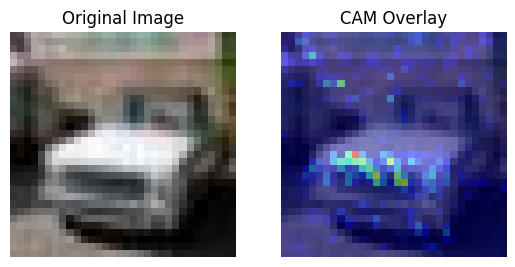

In [70]:
display_cam(index, target_layer="conv1")

Index: 10441
Actual class: Real (1), Predicted class: Real (1)


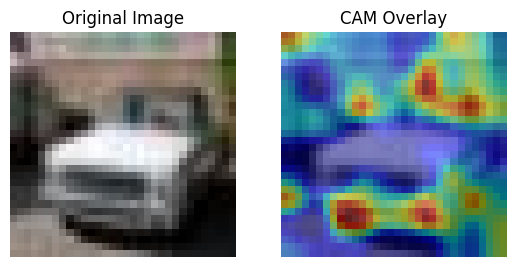

In [71]:
display_cam(index, target_layer="conv2")

[[9036  964]
 [ 445 9555]]


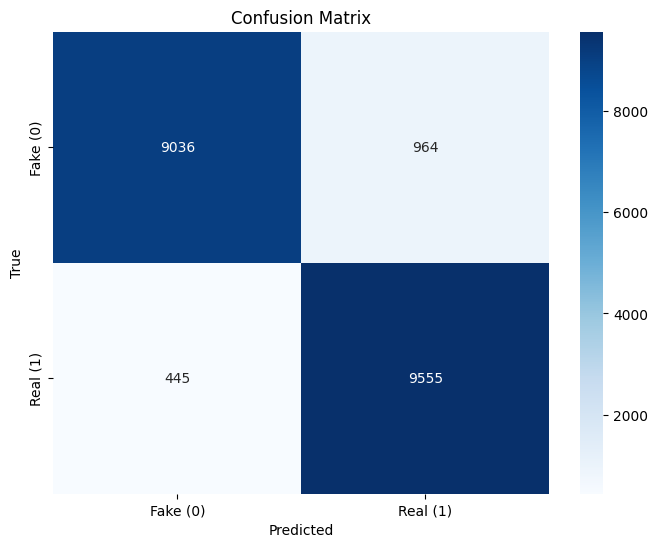

              precision    recall  f1-score   support

    Fake (0)       0.95      0.90      0.93     10000
    Real (1)       0.91      0.96      0.93     10000

    accuracy                           0.93     20000
   macro avg       0.93      0.93      0.93     20000
weighted avg       0.93      0.93      0.93     20000



In [72]:
model.eval()

# Get the predictions for the test set
y_true = []
y_pred = []
for features, target in test_loader:
	features, target = features.to(device), target.to(device)
	output = model(features)
	label_out = torch.argmax(output, dim=1) #argmax returns the index of the maximum value in the tensor
	y_true.extend(target.cpu().numpy())
	y_pred.extend(label_out.cpu().numpy())


# Get the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
print(cm)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Fake (0)", "Real (1)"], yticklabels=["Fake (0)", "Real (1)"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Get the classification report
report = classification_report(y_true, y_pred, target_names=["Fake (0)", "Real (1)"])
print(report)

In [73]:
#get index of everything that's real but predicted fake

ls=[]

for i in range(len(y_pred)):
	if y_pred[i]==0 and y_true[i]==1:
		ls.append(i)

print(ls)

[10001, 10041, 10047, 10068, 10072, 10110, 10127, 10139, 10189, 10190, 10198, 10199, 10240, 10269, 10276, 10280, 10288, 10309, 10318, 10335, 10370, 10386, 10409, 10486, 10509, 10532, 10550, 10555, 10571, 10597, 10609, 10612, 10643, 10671, 10675, 10689, 10692, 10697, 10708, 10746, 10755, 10790, 10815, 10819, 10828, 10835, 10879, 10883, 10939, 10967, 10986, 10999, 11007, 11025, 11042, 11044, 11051, 11089, 11126, 11136, 11143, 11152, 11229, 11286, 11350, 11389, 11402, 11408, 11473, 11534, 11608, 11612, 11623, 11651, 11677, 11749, 11768, 11780, 11825, 11839, 11841, 11852, 11857, 11869, 11922, 11967, 11971, 12028, 12031, 12043, 12093, 12115, 12135, 12169, 12181, 12198, 12229, 12267, 12270, 12271, 12276, 12325, 12398, 12425, 12431, 12447, 12483, 12523, 12548, 12576, 12591, 12612, 12673, 12726, 12745, 12769, 12778, 12787, 12813, 12818, 12861, 12871, 12876, 12909, 12967, 12977, 13001, 13005, 13011, 13033, 13039, 13040, 13079, 13105, 13127, 13141, 13159, 13205, 13208, 13219, 13226, 13230, 13232

In [ ]:
#save model
torch.save(model.state_dict(), "saved_models/CNN_from_scratch/model_full_train_test.pth")